# Verarbeitung und Darstellung der Messdaten


## Import all libraries and load data as pandas dataframe


In [40]:
#import libraries
import pandas as pd
import numpy as np
import scipy.signal as sci
import matplotlib.pyplot as plt

Text(0, 0.5, 'Acceleration [G]')

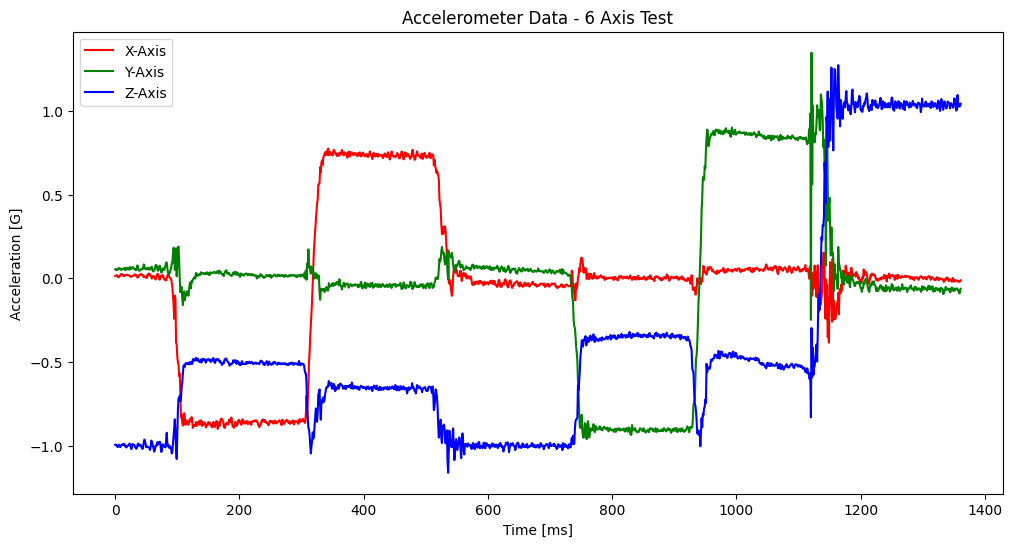

In [41]:
# Aufgabe 5 (Drehen in alle 6 Richtungen)
df = pd.read_csv('Daten/Lab1_IMU_6Achsentest.csv', sep=';')

# Plotting the accelerometer data
plt.figure(figsize=(12, 6))
plt.plot(df['x'], label='X-Axis', color='r')
plt.plot(df['y'], label='Y-Axis', color='g')
plt.plot(df['z'], label='Z-Axis', color='b')
plt.xlabel('Time [ms]')
plt.legend()
plt.title('Accelerometer Data - 6 Axis Test')
plt.ylabel('Acceleration [G]')

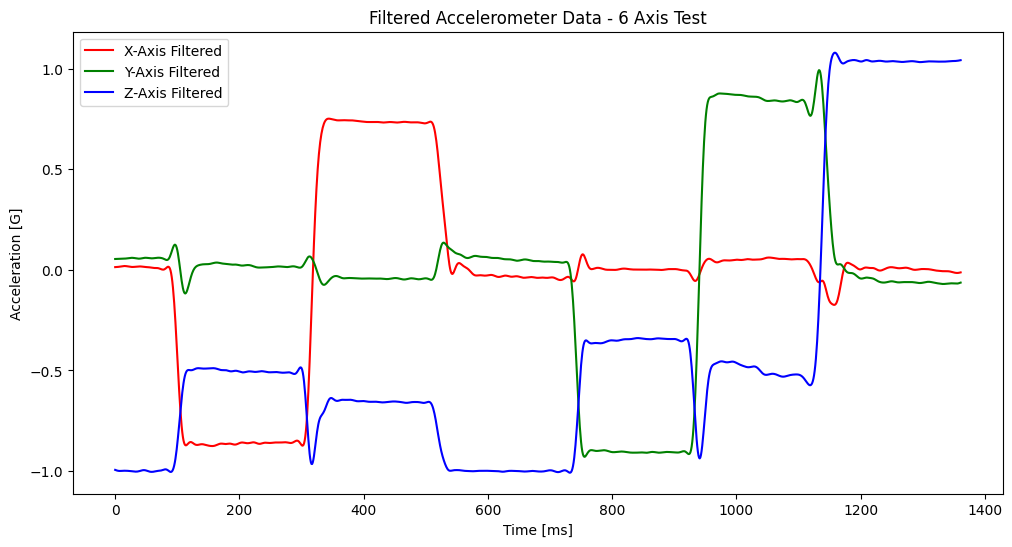

In [42]:
# Aufgabe 6 (Filterung der Daten)
b, a = sci.butter(4, 0.1) # Butterworth filter coefficients
df_filtered = df.copy()
df_filtered['x'] = sci.filtfilt(b, a, df['x'])
df_filtered['y'] = sci.filtfilt(b, a, df['y'])
df_filtered['z'] = sci.filtfilt(b, a, df['z'])

# Darstellen der gefilterten Daten
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['x'], label='X-Axis Filtered', color='r')
plt.plot(df_filtered['y'], label='Y-Axis Filtered', color='g')
plt.plot(df_filtered['z'], label='Z-Axis Filtered', color='b')
plt.legend()
plt.title('Filtered Accelerometer Data - 6 Axis Test')
plt.ylabel('Acceleration [G]')
plt.xlabel('Time [ms]')
plt.show()

Der eingesetzte Butterwort-Filter 4. Ordnung hat erreicht, dass die hochfrequenten Anteile des Signals deutlich reduziert wurden. Dadurch ist das Signal deutlich geglättet und Rauschen wurde entfernt. Da dieser Filter eine hohe Flankensteilheit besitzt, werden die niederfrequenten Anteile des Signals kaum beeinflusst. was zu einer guten Signalqualität führt.

<Axes: title={'center': 'Accelerometer Test'}, xlabel='Time in s', ylabel='Acceleration in g'>

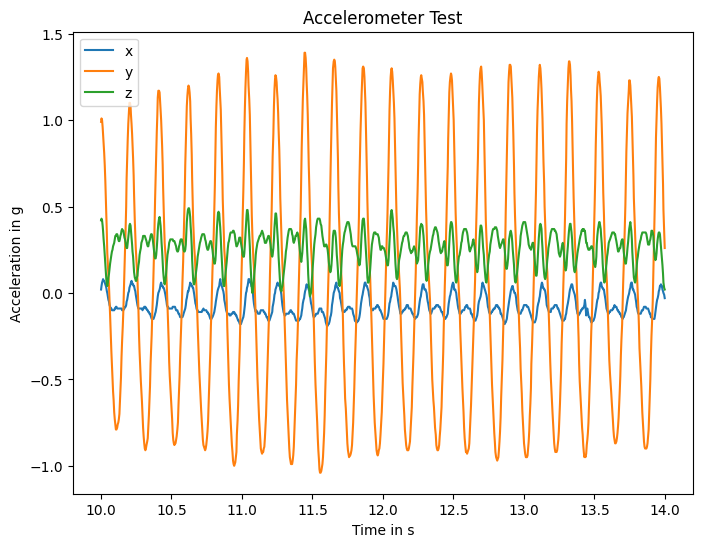

In [43]:
# Aufgabe 8 (a)
# Datei einlesen
df = pd.read_csv("Daten/Lab1_10s-1Achse.txt", sep="\t", decimal=",", encoding="utf-8")
df.to_csv("Daten/Lab1_10s-1Achse.csv", index=False, sep=";") # als Semikolon-CSV speichern
df2 = pd.read_csv("Daten/Lab1_10s-1Achse.csv", sep=";") # CSV-Datei einlesen
df2.columns = ["x", "y", "z", "time_ms"]
df2["time_s"] = df2["time_ms"] / 1000.0 # Zeit in Sekunden umrechnen
df2 = df2[(df2['time_s'] >= 10) & (df2['time_s'] <= 14)] # nur vier Sekunden anzeigen
# display data
df2.plot(x = 'time_s', y = ['x', 'y', 'z'], ylabel='Acceleration in g', 
        xlabel='Time in s', figsize= [8, 6], title="Accelerometer Test")


### Kommentar zum Ergebnis aus Aufgabe 8 (a)
Die Visualisierung zeigt schon die Aufnahme mit richtiger Abtastfrequenz und Einstellen der maximal messbaren Größen in G. Folglich sind Aufgabe 9 und 12 schon implizit erledigt. 

In [44]:
# Aufgabe 10 (Rechnerisches bestimmen der Messfrequenz)

# Zeitdifferenzen zwischen aufeinanderfolgenden Messungen berechnen
time_diffs = df2['time_ms'].diff()

# Mittlere Zeitdifferenz in Millisekunden
mean_time_diff_ms = time_diffs.mean()

# Messfrequenz berechnen (1 / mittlere Zeit in Sekunden)
sampling_frequency = 1000 / mean_time_diff_ms  # in Hz

print(f"Mittlere Zeitdifferenz: {mean_time_diff_ms:.2f} ms")
print(f"Messfrequenz: {sampling_frequency:.2f} Hz")

# Alternative: Gesamtzeit durch Anzahl der Samples
total_time_s = (df2['time_ms'].iloc[-1] - df2['time_ms'].iloc[0]) / 1000
num_samples = len(df2)
sampling_frequency_alt = (num_samples - 1) / total_time_s

print(f"\nAlternative Berechnung:")
print(f"Gesamtzeit: {total_time_s:.2f} s")
print(f"Anzahl Samples: {num_samples}")
print(f"Messfrequenz: {sampling_frequency_alt:.2f} Hz")

Mittlere Zeitdifferenz: 3.96 ms
Messfrequenz: 252.63 Hz

Alternative Berechnung:
Gesamtzeit: 4.00 s
Anzahl Samples: 1011
Messfrequenz: 252.63 Hz


Zu der obigen Berechnung muss gesagt werden, dass die Messung bei einer deutlich höheren Atastfrequenz als 252 Hz durchgeführt wurde (ca. 800 Hz). Daher ist die Visualisierung der mittleren 4 Sekunden schon ausreichend glatt und es sind keine Aliasing-Effekte zu erkennen. Wäre die Abtastfrequenz jedoch wirklich nur 252 Hz, so wären Aliasing-Effekte deutlich sichtbar gewesen.

# Filter acceleration data applying different filter techniques
## Bandpass filter (Butterworth 4. order)

Wir möchten einen Filter verwende, der das Signal nicht verschiebt, demnach einen zero-Phase Filter. Scipy bietet diese Option mit der _filtfilt()_ Methode an. Dieser verwendet zwei _Infinite Impuls Response_ Filter hintereinander geschaltet, jedoch wird der erste vorwärts und der zweite rückwärts angewandt, um keine Phasenverschiebung zu erhalten.

Dies ist auch in folgender Abbildung zu erkennen. Die gestrichelte rote Line stellt einen Filter dar, welcher das Signal filtert und störende Frequenzen entfernt, jedoch ist dieser um eine Phase verschoben zum eigentlichen Signal. Die rote Line ist die zweite Anwendung des Filters. Würde man den zweiten Filter jedoch rückwärts anwenden, würde man die schwarze Linie und somit das Ergebnis der _filtfilt()_ methode erhalten.



![Unterschied zwischen verschiedenen Filtertypen](bilder/zeroPhase.png)

In [45]:
# Setting up a butterworth filter 

def butter_bandpass(lowcut,fs,order=4):
    
    # nyq: Nyquist Theorem
    nyq = 0.5 * fs
    # low is calculated in relation to cutoff frequency and sampling frequency
    low = lowcut / nyq
    
    #order = 4
    
    b, a = sci.butter(order, [low], 'lowpass', analog=False)
    
    return b, a

In [46]:
def butter_bandpass_filter(signal, lowcut, fs, order=4):
    #use filtfilt for a zero-phase filtering
    b, a = butter_bandpass(lowcut,fs, order)
    y = sci.filtfilt(b, a, signal, axis = 0)
    return y